In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

2022-11-23 14:15:43.174038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 14:15:43.278477: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-23 14:15:43.684998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.4/lib64::/home/marc/anaconda3/envs/gr/include/:/lib/:/home/marc/.mujoco/mujoco200/bin:/home/marc/.mujoco/mujoco200/bin
2022-11-23 14:15:43.

In [2]:
from glob import glob
import os
import pickle

In [3]:
from functools import partial  # pylint: disable=g-importing-member
import os
import pickle
import time
import jax
from jax import jit
from jax import random
from jax import vmap
import jax.numpy as jnp
import ml_collections
import numpy as np
import tensorflow as tf
import diffusion
import ode_datasets
import samplers
import unet
from oil.logging.lazyLogger import LazyLogger
from oil.utils.utils import FixedNumpySeed
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

/home/marc/anaconda3/envs/diff2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
base_path = './all_datasets2'#'./all_datasets4_noic'#'./all_datasets2'
run_path = 'trial4'#'trial4'
obj_name = 'config'
state = []
for name in ['config','data_std','params']:
    with open(os.path.join(base_path,run_path,name), 'rb') as f:
        state.append(pickle.load(f))
    
config, data_std, params = state

In [61]:
config

attention: false
bs: 500
channels: 32
dataset: NPendulum
dataset_timesteps: 60
difftype: VarianceExploding
ds: 4000
epochs: 10000
ic_conditioning: false
log_dir: all_datasets2
log_suffix: trial4/
lr: 0.0001
noisetype: Identity
seed: 37
study_name: all_datasets2

In [62]:
key = random.PRNGKey(config.seed)
# Construct the dataset
timesteps = config.dataset_timesteps
with FixedNumpySeed(config.seed):
    ds = getattr(ode_datasets, config.dataset)(N=config.bs)
trajectories = ds.Zs[:config.bs, :timesteps]
test_x = ds.Zs[:config.bs, :timesteps]
#data_std = trajectories.std()
T_long = ds.T_long[:timesteps]  # pylint: disable=invalid-name
dataset = tf.data.Dataset.from_tensor_slices(trajectories)
dataiter = dataset.shuffle(len(dataset)).batch(config.bs).as_numpy_iterator
assert trajectories.shape[1] == timesteps, "inconsistent data sizes"

# initialize the model
x = test_x  # (bs, N, C)
modelconfig = unet.unet_64_config(
  x.shape[-1], base_channels=config.channels, attention=config.attention)
model = unet.UNet(modelconfig)
noise = getattr(diffusion, config.noisetype)
diff = getattr(diffusion, config.difftype)(noise)
# whether or not to condition on initial timesteps
cond_fn = lambda z: (z[:, :3] if config.ic_conditioning else None)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.01it/s]


In [63]:
from diffusion import unsqueeze_like
def score(params,
            x,
            t,
            train = True,
            cond = None):
    """Score function with appropriate input and output scaling."""
    # scaling is equivalent to that in https://arxiv.org/abs/2206.00364
    sigma, scale = unsqueeze_like(x, diff.sigma(t), diff.scale(t))
    input_scale = 1 / jnp.sqrt(sigma**2 + (scale * data_std)**2)
    cond = cond / data_std if cond is not None else None
    out = model.apply(params, x=x * input_scale, t=t, train=train, cond=cond)
    return out / jnp.sqrt(sigma**2 + scale**2 * data_std**2)
@jit
def score_fn(x,t,cond = None):
    """Trained score function s(xₜ,t):=∇logp(xₜ)."""
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return score(params, x, t, train=False, cond=cond)

In [64]:
z0 = ds.sample_initial_conditions(test_x.shape[0])
if config.dataset != 'NPendulum':
    z0 = vmap(ds.integrate,(0,None),0)(z0,jnp.array([0,T_long[0]]))[:,-1]
# if config.dataset=='NPendulum':
#     T0 = T_long
# else:
#     T0 = jnp.insert(T_long,0,0.)
T0 = T_long - T_long[0]
z_gta = vmap(ds.integrate,(0,None),0)(z0,T0)
z_perta = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T0)
z_randoma = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T0)

zs = [z_gta,z_perta,z_randoma]



for i in range(3):
    if config.dataset=='NPendulum':
        qs, ps = ode_datasets.unpack(zs[i])
        zs[i] = jnp.concatenate([jnp.sin(qs),jnp.cos(qs)],-1)
    else:
        zs[i] = zs[i]#[:,1:]
z_gt,z_pert,z_random = zs

if config.dataset=='NPendulum':
    qs, ps = ode_datasets.unpack(z0)#z_gt[:,0])
    vs = jnp.linalg.solve(vmap(ds.mass)(qs),ps)
    z0_node = ode_datasets.pack(qs,vs)
else:
    z0_node = z_gt[:,0]

In [65]:
# z0 = ds.sample_initial_conditions(test_x.shape[0])
# jnp.isnan(z0).mean((-1,-2))

In [66]:
from flax import linen as nn
from typing import Sequence
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.swish(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x
from jax.experimental.ode import odeint
base_path = './node_all'
run_path = 'trial{}'.format({'LorenzDataset':0,'FitzHughDataset':1,'NPendulum':2}[config.dataset])
obj_name = 'config'
state = []
for name in ['config','params']:
    with open(os.path.join(base_path,run_path,name), 'rb') as f:
        state.append(pickle.load(f))
    
nconfig, nparams = state


nkey = random.PRNGKey(42) if nconfig['seed'] is None else random.PRNGKey(nconfig['seed'])
nkey, ninit_seed = random.split(key)
node_model = MLP([128,128,trajectories.shape[-1]])
_ = node_model.init(ninit_seed, x=trajectories[0])
T_short = T_long[:nconfig['chunk_size']]-T_long[0]
F = lambda x,t: node_model.apply(nparams,x)/T_short[-1]

node_preda = odeint(F, z0_node, T_long-T_long[0], rtol=1e-3).transpose((1,0,2))
print(node_preda.shape)
if config.dataset=='NPendulum':
    qs, ps = ode_datasets.unpack(node_preda)
    node_pred = jnp.concatenate([jnp.sin(qs),jnp.cos(qs)],-1)
else:
    node_pred = node_preda

(500, 60, 4)


In [67]:
config

attention: false
bs: 500
channels: 32
dataset: NPendulum
dataset_timesteps: 60
difftype: VarianceExploding
ds: 4000
epochs: 10000
ic_conditioning: false
log_dir: all_datasets2
log_suffix: trial4/
lr: 0.0001
noisetype: Identity
seed: 37
study_name: all_datasets2

In [68]:
#T_long-T_long[0]

In [69]:
#T_long[:10]-T_long[0]

In [70]:
#jnp.abs(node_preda[:,:10]-z_gt[:,:10]).mean()

In [71]:
#plt.plot(node_preda[17])

In [72]:
#plt.plot(z_gt[17])

In [73]:
#node_preda[:5,0,1]

In [74]:
#z_gt[:5,0,1]

In [75]:
if config.ic_conditioning:
    eval_score_fn = partial(score_fn,cond=cond_fn(z_gt))
else:
    slc = slice(3)
    alpha = {'LorenzDataset':100,'FitzHughDataset':40,'NPendulum':30}[config.dataset]
    eval_score_fn = samplers.inpainting_scores(diff, score_fn, z_gt[:,slc],slc,alpha=alpha)
sde_samples = samplers.sde_sample(diff, eval_score_fn, key, test_x.shape,nsteps=1000)

In [76]:
from tqdm import tqdm
all_samples = []
expanded = (z_gt[None,:]+jnp.zeros((4,1,1,1))).reshape(-1,*z_gt.shape[1:])
#expanded = z_gt
eval_score_fn = jit(samplers.inpainting_scores(diff, score_fn, expanded[:,slc],slc,alpha=alpha))
for i in range(5):
    key,_ = jax.random.split(key)
    esde_samples = samplers.sde_sample(diff, eval_score_fn, key, expanded.shape,nsteps=1000)
    all_samples.append(esde_samples)
    
all_samples = jnp.stack(all_samples,0).reshape(-1,*z_gt.shape)
medians = jnp.median(all_samples,0)

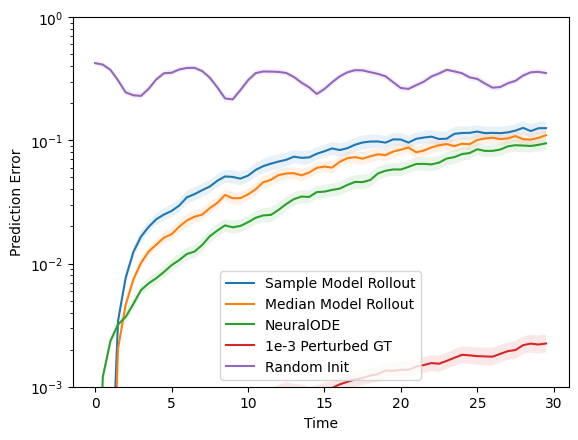

In [77]:
from jax import vmap
import train
import matplotlib.pyplot as plt
#
T = T_long
z1 = medians#sde_samples
#z_gts = test_x[:z1.shape[0]]
#z0 = z_gts[:,0]#z_gts[:,0]


# z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T)
# z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T)
errs = []
stds= []
names = ['Sample Model Rollout','Median Model Rollout', 'NeuralODE','1e-3 Perturbed GT','Random Init']
for pred,label in zip([all_samples[0],z1,node_pred,z_pert,z_random],names):
    pred = jnp.where(jnp.isnan(pred),jnp.zeros_like(pred),pred)
    clamped_errs = jax.lax.clamp(1e-5,train.rel_err(pred,z_gt),np.inf)
    rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
    rel_stds = np.exp(2*jnp.log(clamped_errs).std(0)/jnp.sqrt(clamped_errs.shape[0]))
    errs.append(rel_errs)
    stds.append(rel_stds)
    plt.plot(T,rel_errs,label=label)
    plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.ylim(1e-3,1)
plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend()

data_dict = dict(zip(names,zip(errs,stds)))
with open(f'{config.dataset}_rollouts2', 'wb') as f:
    pickle.dump(data_dict,f)

In [169]:
# with open(f'{config.dataset}_rollouts', 'rb') as f:
#     data_dict = pickle.load(f)
# print(data_dict)

In [170]:
expanded = (z_gt[None,::20]+jnp.zeros((20,1,1,1))).reshape(z_gt.shape)
if config.ic_conditioning:
    unc_score_fn = partial(score_fn,cond=cond_fn(expanded))
else:
    slc = slice(3)
    unc_score_fn = samplers.inpainting_scores(diff, score_fn, expanded[:,slc],slc,alpha=100.)
unc_score_fn = jit(unc_score_fn)

In [171]:
predictions = samplers.sde_sample(diff, unc_score_fn , key, test_x.shape,nsteps=1000)

In [172]:
preds = predictions.reshape(20,-1,*predictions.shape[1:])
upper = jnp.quantile(preds,.8,0)
lower = jnp.quantile(preds,.2,0)

In [173]:
with open(f'{config.dataset}_expanded_rollouts', 'wb') as f:
    pickle.dump(preds,f)
with open(f'{config.dataset}_gt', 'wb') as f:
    pickle.dump(z_gt,f)

In [8]:
def lorenz_C(x):
    fourier_mag = jnp.abs(jnp.fft.rfft(x[...,0],axis=-1))
    return -(fourier_mag[...,1:].mean(-1)-.6)

def fitz_C(x):
    C = jnp.max(x[...,:2].mean(-1),-1)-2.5
    return C

def pendulum_C(x):
    raise NotImplementedError

constraints = {'FitzHughDataset':fitz_C,
          'LorenzDataset': lorenz_C,
          'NPendulum':pendulum_C,
          }
event_constraint = constraints[config.dataset]

In [8]:
regs = [.01,.1,1.,10,100,1000,10000]
for i,reg in enumerate(regs):
    bad_event_scores = samplers.bad_event_scores(diff,score_fn, event_constraint, reg=reg)
    bad_sde_event_samples = samplers.sde_sample(diff, bad_event_scores, key, test_x.shape,nsteps=1000)
    with open(f'{config.dataset}_bad_sde_event_samples_{i}', 'wb') as f:
        pickle.dump(bad_sde_event_samples,f)

In [11]:
event_scores = samplers.event_scores(diff,score_fn, event_constraint, reg=1e-3)
sde_event_samples = samplers.sde_sample(diff, event_scores, key, test_x.shape,nsteps=1000)

In [126]:
with open(f'{config.dataset}_sde_event_samples', 'wb') as f:
    pickle.dump(sde_event_samples,f)
    
with open(f'{config.dataset}_cond_sde_samples', 'wb') as f:
    pickle.dump(sde_samples,f)
    
with open(f'{config.dataset}_uncond_sde_samples', 'wb') as f:
    pickle.dump(uncond_sde_samples,f)

In [ ]:
all_conditional = []
for i in range(3,5):
    conditional_likelihood = samplers.discrete_time_likelihood(diff, event_scores, sde_event_samples[i][None],nsteps=250)
    all_conditional.append(conditional_likelihood)
    print(all_conditional)
#conditional_likelihood = samplers.discrete_time_likelihood(diff, event_scores, sde_event_samples[:1],nsteps=500)


In [12]:
all_unconditional = []
for i in range(3,5):
    unconditional_likelihood = samplers.discrete_time_likelihood(diff, score_fn, sde_event_samples[i][None],nsteps=250)
    all_unconditional.append(unconditional_likelihood)
    print(all_unconditional)

[DeviceArray([1207.2546], dtype=float32)]
[DeviceArray([1207.2546], dtype=float32), DeviceArray([1231.9889], dtype=float32)]


In [17]:
1/jnp.exp(conditional_likelihood-unconditional_likelihood)

DeviceArray([0.11532117], dtype=float32)

In [18]:
print(conditional_likelihood)
print(unconditional_likelihood)

[1208.745]
[1206.585]


In [24]:
all_conditional = [1208.745]

In [ ]:
#plt.plot(T_long,preds[:,7,:].mean(-1).T)

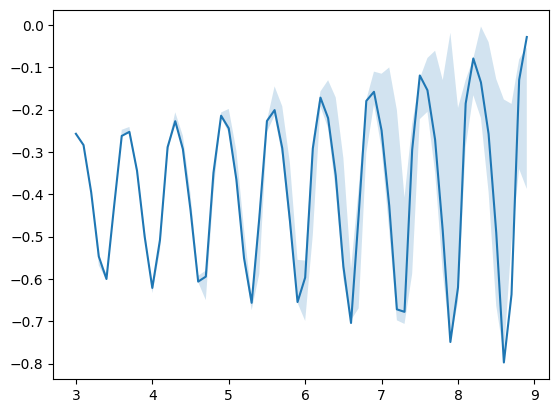

In [78]:
i=13
plt.fill_between(T_long,lower[i,:,1],upper[i,:,1],alpha=.2)
plt.plot(T_long,expanded[i,:,1])


In [83]:
q = .1+(np.arange(9))/10.
qs = jnp.quantile(preds,q,axis=0)

In [84]:
preds.shape

(20, 25, 60, 3)

In [85]:
q

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [86]:
preds[:,7,10,1]

DeviceArray([-0.55223674, -0.5950307 , -0.55766106, -0.55056876,
             -0.54791445, -0.5529056 , -0.55552155, -0.54904836,
             -0.5511545 , -0.55248183, -0.5538549 , -0.5580028 ,
             -0.5600012 , -0.55116737, -0.5506118 , -0.55151397,
             -0.5554289 , -0.55442023, -0.5569545 , -0.55540633],            dtype=float32)

In [87]:
jnp.percentile(preds[:,7,10,1],q*100,axis=0)

DeviceArray([-0.5582026 , -0.5570958 , -0.5554567 , -0.5548147 ,
             -0.55338025, -0.5523838 , -0.55140996, -0.55104595,
             -0.5504167 ], dtype=float32)

In [88]:
flat_qs = qs.reshape(9,-1).T
flat_gts = z_gt[::20].reshape(-1)

In [89]:
qs.shape

(9, 25, 60, 3)

In [90]:
z_gt[::20].shape

(25, 60, 3)

In [91]:
bins = vmap(partial(jnp.digitize,right=True))(flat_gts,flat_qs)

In [92]:
binvals = jnp.stack([(bins.reshape(qs.shape[1:])<=i).mean(axis=(0,-1)) for i in range(10)],0)

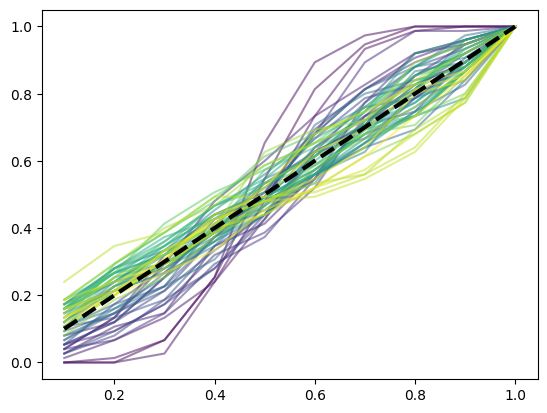

In [93]:
colors = plt.cm.viridis(np.linspace(0,1,binvals.shape[1]))
#plt.set_cmap('jet')
#plt.plot(np.arange(binvals.shape[0]),binvals)
for bval,c in zip(binvals.T[:],colors):
    plt.plot((1+np.arange(binvals.shape[0]))/10,bval,color=c,alpha=.5)
plt.plot((1+np.arange(binvals.shape[0]))/10,(1+np.arange(binvals.shape[0]))/10.,'--',lw=3,color='k')
#plt.colorbar()

(array([504., 369., 373., 507., 483., 528., 465., 421., 371., 479.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

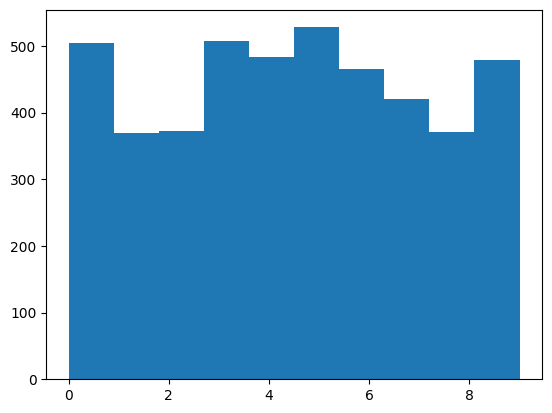

In [94]:
plt.hist(bins)

In [ ]:
outcome 0  0.009612                                                                                                     
outcome 1  0.178891                                                                                                     
outcome 2  0.090275

In [ ]:
outcome 0  0.006363
outcome 1  0.021298
outcome 2  0.059863